Line Modeling simulation with [PowerSimulationsDynamics.jl](https://github.com/NREL-SIIP/PowerSimulationsDynamics.jl)

**Originally Contributed by**: José Daniel Lara

## Introduction

This tutorial will introduce the modeling of an inverter with Virtual Inertia in a multi-machine
model of the system. We will load the data directly from PSS/e dynamic files

The tutorial uses a modified 14-bus system on which all the synchronous machines have been
substituted by generators with ESAC1A AVR's and no Turbine Governors.

In the first portion of the tutorial we will simulate the system with the original data and
cause a line trip between Buses 2 and 4. In the second part of the simulation, we will switch
generator 6 with a battery using an inverter and perform the same fault.

Load the packages

In [1]:
using SIIPExamples # Only needed for the tutorial, comment if you want to run
import DisplayAs # Only needed for the tutorial
using PowerSimulationsDynamics
using PowerSystems
using Logging
using Sundials
using Plots
gr()
PSD = PowerSimulationsDynamics

PowerSimulationsDynamics

Create the system

In [2]:
file_dir = joinpath(
    dirname(dirname(pathof(SIIPExamples))),
    "script",
    "4_PowerSimulationsDynamics_examples",
    "Data",
)

sys = System(joinpath(file_dir, "14bus.raw"), joinpath(file_dir, "dyn_data.dyr"))

[ Info: The PSS(R)E parser currently supports buses, loads, shunts, generators, branches, transformers, and dc lines
[ Info: The PSS(R)E parser currently supports buses, loads, shunts, generators, branches, transformers, and dc lines
[ Info: The following fields in GENERATOR are missing: O2, F2, O3, F3, O4, F4, WMOD, WPF
[ Info: The following fields in GENERATOR are missing: O2, F2, O3, F3, O4, F4, WMOD, WPF
[ Info: The following fields in GENERATOR are missing: O2, F2, O3, F3, O4, F4, WMOD, WPF
[ Info: The following fields in GENERATOR are missing: O2, F2, O3, F3, O4, F4, WMOD, WPF
[ Info: The following fields in GENERATOR are missing: O2, F2, O3, F3, O4, F4, WMOD, WPF
[ Info: The following fields in BRANCH are missing: O2, F2, O3, F3, O4, F4
[ Info: The following fields in BRANCH are missing: O2, F2, O3, F3, O4, F4
[ Info: The following fields in BRANCH are missing: O2, F2, O3, F3, O4, F4
[ Info: The following fields in BRANCH are missing: O2, F2, O3, F3, O4, F4
[ Info: The following

System
┌───────────────────┬─────────────┐
│ Property          │ Value       │
├───────────────────┼─────────────┤
│ System Units Base │ SYSTEM_BASE │
│ Base Power        │ 100.0       │
│ Base Frequency    │ 60.0        │
│ Num Components    │ 77          │
└───────────────────┴─────────────┘

Static Components
┌─────────────────┬───────┬────────────────────────┬───────────────┐
│ Type            │ Count │ Has Static Time Series │ Has Forecasts │
├─────────────────┼───────┼────────────────────────┼───────────────┤
│ Arc             │ 20    │ false                  │ false         │
│ Area            │ 1     │ false                  │ false         │
│ Bus             │ 14    │ false                  │ false         │
│ Line            │ 16    │ false                  │ false         │
│ LoadZone        │ 1     │ false                  │ false         │
│ PowerLoad       │ 11    │ false                  │ false         │
│ TapTransformer  │ 3     │ false                  │ false         │
│ ThermalStandard │ 5     │ false                  │ false         │
│ Transformer2W   │ 1     │ false                  │ false         │
└─────────────────┴───────┴────────────────────────┴───────────────┘

Dynamic Components
┌───────────────────────────────────────────────────────────────────────────────
│ Type                                                                         ⋯
├───────────────────────────────────────────────────────────────────────────────
│ DynamicGenerator{PowerSystems.RoundRotorQuadratic, PowerSystems.SingleMass,  ⋯
│ DynamicGenerator{PowerSystems.RoundRotorQuadratic, PowerSystems.SingleMass,  ⋯
└───────────────────────────────────────────────────────────────────────────────
                                                               2 columns omitted

Define Simulation Problem with a 20 second simulation period and the branch trip at t = 1.0

In [3]:
sim = PSD.Simulation(
    ResidualModel, #Type of model used
    sys,         #system
    file_dir,       #path for the simulation output
    (0.0, 20.0), #time span
    BranchTrip(1.0, Line, "BUS 02-BUS 04-i_4");
    console_level = Logging.Info,
)

[ Info: Unit System changed to InfrastructureSystems.UnitSystemModule.UnitSystem.DEVICE_BASE = 1
[ Info: Validating connectivity with Goderya algorithm
[ Info: The System has no islands
[ Info: Pre-Initializing Simulation States
[ Info: Unit System changed to InfrastructureSystems.UnitSystemModule.UnitSystem.SYSTEM_BASE = 0
[ Info: Validating connectivity with Goderya algorithm
[ Info: The System has no islands
[ Info: PowerFlow solve converged, the results have been stored in the system
[ Info: Unit System changed to InfrastructureSystems.UnitSystemModule.UnitSystem.DEVICE_BASE = 1
[ Info: Initialization succeeded with a tolerance of 1.0e-7 using solver trust_region. Saving solution.
[ Info: Attaching Perturbations
[ Info: Simulations status = BUILT
┌ Info: 
│  ─────────────────────────────────────────────────────────────────────────────
│                                                     Time         Allocations  
│                                                ──────────────   ──

Property,Value
Simulation Type,Residual Model
Initialized?,Yes
Multimachine system?,Yes
Time Span,"(0.0, 20.0)"
Number of States,86
Number of Perturbations,1


Now that the system is initialized, we can verify the system states for potential issues.

In [4]:
show_states_initial_value(sim)

Voltage Variables
BUS 01
Vm 1.06
θ 0.0
BUS 02
Vm 1.04
θ -0.0711
BUS 03
Vm 1.01
θ -0.1787
BUS 04
Vm 1.0129
θ -0.1458
BUS 05
Vm 1.0165
θ -0.1235
BUS 06
Vm 1.06
θ -0.1949
BUS 07
Vm 1.0438
θ -0.1812
BUS 08
Vm 1.08
θ -0.1656
BUS 09
Vm 1.0263
θ -0.2102
BUS 10
Vm 1.0245
θ -0.2125
BUS 11
Vm 1.0384
θ -0.2059
BUS 12
Vm 1.0436
θ -0.2105
BUS 13
Vm 1.0372
θ -0.2119
BUS 14
Vm 1.0126
θ -0.2291
Differential States
generator-3-1
eq_p 1.0649
ed_p 0.1243
ψ_kd 0.9872
ψ_kq 0.2132
δ 0.034
ω 1.0
Vm 1.01
Vr1 0.006
Vr2 2.419
Ve 1.791
Vr3 -0.0726
Differential States
generator-8-1
eq_p 1.2657
ed_p 0.0462
ψ_kd 1.1584
ψ_kq 0.1748
δ 0.019
ω 1.0
Vm 1.08
Vr1 0.0097
Vr2 3.9162
Ve 2.8839
Vr3 -0.1175
Differential States
generator-1-1
eq_p 1.0604
ed_p -0.0111
ψ_kd 1.0563
ψ_kq 0.1134
δ 0.1684
ω 1.0
Vm 1.06
Vr1 0.0049
Vr2 1.951
Ve 1.4049
Vr3 -0.0585
x_g1 0.3144
x_g2 0.3144
x_g3 0.3144
Differential States
generator-2-1
eq_p 1.1038
ed_p 0.1491
ψ_kd 1.003
ψ_kq 0.2748
δ 0.1963
ω 1.0
Vm 1.04
Vr1 0.0071
Vr2 2.8613
Ve 2.1338
Vr3 

We execute the simulation with an additional tolerance for the solver set at 1e-8.

In [5]:
PSD.execute!(sim, IDA(); abstol = 1e-8)

SIMULATION_FINALIZED::BUILD_STATUS = 6

Using `PowerSimulationsDynamics` tools for exploring the results, we can plot all the voltage
results for the buses

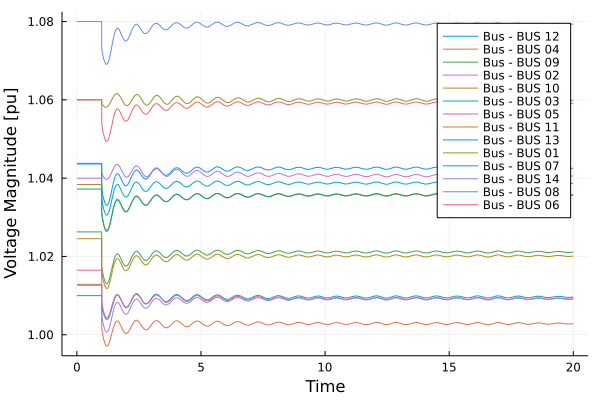

In [6]:
result = read_results(sim)
p = plot()
for b in get_components(Bus, sys)
    voltage_series = get_voltage_magnitude_series(result, get_number(b))
    plot!(
        p,
        voltage_series;
        xlabel = "Time",
        ylabel = "Voltage Magnitude [pu]",
        label = "Bus - $(get_name(b))",
    )
end
img = DisplayAs.PNG(p) # This line is only needed because of literate use display(p) when running locally

We can also explore the frequency of the different generators

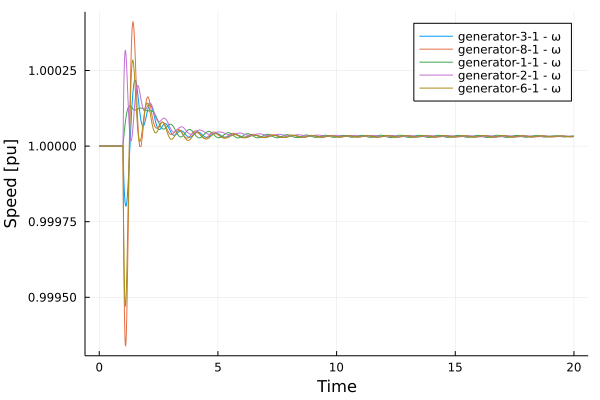

In [7]:
p2 = plot()
for g in get_components(ThermalStandard, sys)
    state_series = get_state_series(result, (get_name(g), :ω))
    plot!(
        p2,
        state_series;
        xlabel = "Time",
        ylabel = "Speed [pu]",
        label = "$(get_name(g)) - ω",
    )
end
img = DisplayAs.PNG(p2) # This line is only needed because of literate use display(p2) when running locally

It is also possible to explore the small signal stability of this system we created. However,
Since a simulation has already taken place, we need to reset the model.

In [8]:
res = small_signal_analysis(sim; reset_simulation = true)

┌ Warning: No Infinite Bus found. Confirm stability directly checking eigenvalues.
│ If all eigenvalues are on the left-half plane and only one eigenvalue is zero, the system is small signal stable.
└ @ PowerSimulationsDynamics ~/.julia/packages/PowerSimulationsDynamics/R8NqS/src/base/small_signal.jl:111
┌ Info: Eigenvalues are:
│ -1000.0000000000011 + 0.0im
│ -1000.0000000000011 + 0.0im
│ -1000.0000000000005 + 0.0im
│ -999.9999999999998 + 0.0im
│ -999.999999999998 + 0.0im
│ -51.779609831814625 + 0.0im
│ -51.63111586631127 + 0.0im
│ -51.48196983034091 + 0.0im
│ -51.454486265473065 + 0.0im
│ -51.3740039674014 + 0.0im
│ -43.51910470435356 + 0.0im
│ -36.941879604511364 + 0.0im
│ -33.11983630379102 + 0.0im
│ -30.368766297045823 + 0.0im
│ -28.13355385743893 + 0.0im
│ -23.815736655120237 + 0.0im
│ -20.610224285005486 + 0.0im
│ -18.225468892692835 + 0.0im
│ -15.843534560814728 + 0.0im
│ -12.400119210642332 + 0.0im
│ -7.11564287037651 - 0.1661292474255282im
│ -7.11564287037651 + 0.166129247425

The system is small signal stable


The eigenvalues can be explored visually

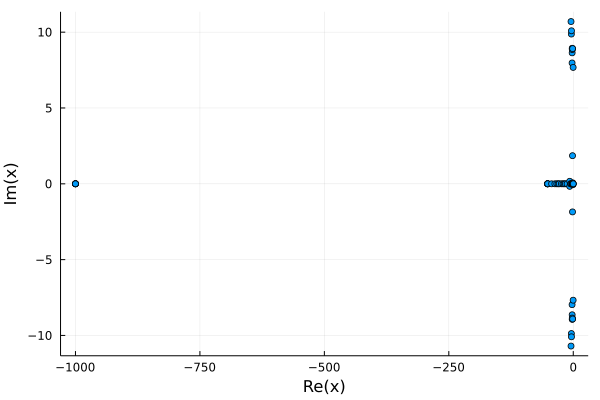

In [9]:
scatter(res.eigenvalues; legend = false)

## Modifying the system and adding storage

Reload the system for this example

In [10]:
sys = System(joinpath(file_dir, "14bus.raw"), joinpath(file_dir, "dyn_data.dyr"))

[ Info: The PSS(R)E parser currently supports buses, loads, shunts, generators, branches, transformers, and dc lines
[ Info: The PSS(R)E parser currently supports buses, loads, shunts, generators, branches, transformers, and dc lines
[ Info: The following fields in GENERATOR are missing: O2, F2, O3, F3, O4, F4, WMOD, WPF
[ Info: The following fields in GENERATOR are missing: O2, F2, O3, F3, O4, F4, WMOD, WPF
[ Info: The following fields in GENERATOR are missing: O2, F2, O3, F3, O4, F4, WMOD, WPF
[ Info: The following fields in GENERATOR are missing: O2, F2, O3, F3, O4, F4, WMOD, WPF
[ Info: The following fields in GENERATOR are missing: O2, F2, O3, F3, O4, F4, WMOD, WPF
[ Info: The following fields in BRANCH are missing: O2, F2, O3, F3, O4, F4
[ Info: The following fields in BRANCH are missing: O2, F2, O3, F3, O4, F4
[ Info: The following fields in BRANCH are missing: O2, F2, O3, F3, O4, F4
[ Info: The following fields in BRANCH are missing: O2, F2, O3, F3, O4, F4
[ Info: The following

System
┌───────────────────┬─────────────┐
│ Property          │ Value       │
├───────────────────┼─────────────┤
│ System Units Base │ SYSTEM_BASE │
│ Base Power        │ 100.0       │
│ Base Frequency    │ 60.0        │
│ Num Components    │ 77          │
└───────────────────┴─────────────┘

Static Components
┌─────────────────┬───────┬────────────────────────┬───────────────┐
│ Type            │ Count │ Has Static Time Series │ Has Forecasts │
├─────────────────┼───────┼────────────────────────┼───────────────┤
│ Arc             │ 20    │ false                  │ false         │
│ Area            │ 1     │ false                  │ false         │
│ Bus             │ 14    │ false                  │ false         │
│ Line            │ 16    │ false                  │ false         │
│ LoadZone        │ 1     │ false                  │ false         │
│ PowerLoad       │ 11    │ false                  │ false         │
│ TapTransformer  │ 3     │ false                  │ false         │
│ ThermalStandard │ 5     │ false                  │ false         │
│ Transformer2W   │ 1     │ false                  │ false         │
└─────────────────┴───────┴────────────────────────┴───────────────┘

Dynamic Components
┌───────────────────────────────────────────────────────────────────────────────
│ Type                                                                         ⋯
├───────────────────────────────────────────────────────────────────────────────
│ DynamicGenerator{PowerSystems.RoundRotorQuadratic, PowerSystems.SingleMass,  ⋯
│ DynamicGenerator{PowerSystems.RoundRotorQuadratic, PowerSystems.SingleMass,  ⋯
└───────────────────────────────────────────────────────────────────────────────
                                                               2 columns omitted

We want to remove the generator 6 and the dynamic component attached to it.

In [11]:
thermal_gen = get_component(ThermalStandard, sys, "generator-6-1")
remove_component!(sys, get_dynamic_injector(thermal_gen))
remove_component!(sys, thermal_gen)

We can now define our storage device and add it to the system

In [12]:
storage = GenericBattery(
    name = "Battery",
    bus = get_component(Bus, sys, "BUS 06"),
    available = true,
    prime_mover = PrimeMovers.BA,
    active_power = 0.6,
    reactive_power = 0.16,
    rating = 1.1,
    base_power = 25.0,
    initial_energy = 50.0,
    state_of_charge_limits = (min = 5.0, max = 100.0),
    input_active_power_limits = (min = 0.0, max = 1.0),
    output_active_power_limits = (min = 0.0, max = 1.0),
    reactive_power_limits = (min = -1.0, max = 1.0),
    efficiency = (in = 0.80, out = 0.90),
)

add_component!(sys, storage)

A good sanity check it running a power flow on the system to make sure all the components
are properly scaled and that the system is properly balanced. We can use `PowerSystems` to
perform this check. We can get the results back and perform a sanity check

In [13]:
res = solve_powerflow(sys)
res["bus_results"]

[ Info: Validating connectivity with Goderya algorithm
[ Info: The System has no islands
[ Info: PowerFlow solve converged, the results are exported in DataFrames
[ Info: Voltages are exported in pu. Powers are exported in MW/MVAr.


,bus_number,Vm,θ,P_gen,P_load,P_net,Q_gen,Q_load,Q_net
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,1.06,0.0,193.33,0.0,193.33,1.12086,0.0,1.12086
2,2,1.04,-0.0711029,30.0,21.7,8.3,27.0157,12.7,14.3157
3,3,1.01,-0.178704,20.0,94.2,-74.2,21.719,19.0,2.71896
4,4,1.01285,-0.145825,0.0,47.8,-47.8,0.0,0.0,0.0
5,5,1.01648,-0.123536,0.0,7.6,-7.6,0.0,1.6,-1.6
6,6,1.06,-0.194906,15.0,11.2,3.8,14.8004,7.5,7.3004
7,7,1.04377,-0.181188,0.0,0.0,0.0,0.0,0.0,0.0
8,8,1.08,-0.165561,10.0,0.0,10.0,22.2916,0.0,22.2916
9,9,1.02628,-0.210231,0.0,29.5,-29.5,0.0,16.6,-16.6


After verifying that the system works, we can define our inverter dynamics and add it to the
battery that has already been stored in the system.

In [14]:
inverter = DynamicInverter(
    name = get_name(storage),
    ω_ref = 1.0, # ω_ref,
    converter = AverageConverter(rated_voltage = 138.0, rated_current = 100.0),
    outer_control = OuterControl(
        VirtualInertia(Ta = 2.0, kd = 400.0, kω = 20.0),
        ReactivePowerDroop(kq = 0.2, ωf = 1000.0),
    ),
    inner_control = CurrentControl(
        kpv = 0.59,     #Voltage controller proportional gain
        kiv = 736.0,    #Voltage controller integral gain
        kffv = 0.0,     #Binary variable enabling the voltage feed-forward in output of current controllers
        rv = 0.0,       #Virtual resistance in pu
        lv = 0.2,       #Virtual inductance in pu
        kpc = 1.27,     #Current controller proportional gain
        kic = 14.3,     #Current controller integral gain
        kffi = 0.0,     #Binary variable enabling the current feed-forward in output of current controllers
        ωad = 50.0,     #Active damping low pass filter cut-off frequency
        kad = 0.2,
    ),
    dc_source = FixedDCSource(voltage = 600.0),
    freq_estimator = KauraPLL(
        ω_lp = 500.0, #Cut-off frequency for LowPass filter of PLL filter.
        kp_pll = 0.084,  #PLL proportional gain
        ki_pll = 4.69,   #PLL integral gain
    ),
    filter = LCLFilter(lf = 0.08, rf = 0.003, cf = 0.074, lg = 0.2, rg = 0.01),
)
add_component!(sys, inverter, storage)

┌ Warning: struct DynamicInverter does not exist in validation configuration file, validation skipped
└ @ InfrastructureSystems ~/.julia/packages/InfrastructureSystems/FWgY0/src/validation.jl:51


These are the current system components:

In [15]:
sys

System
┌───────────────────┬─────────────┐
│ Property          │ Value       │
├───────────────────┼─────────────┤
│ System Units Base │ SYSTEM_BASE │
│ Base Power        │ 100.0       │
│ Base Frequency    │ 60.0        │
│ Num Components    │ 77          │
└───────────────────┴─────────────┘

Static Components
┌─────────────────┬───────┬────────────────────────┬───────────────┐
│ Type            │ Count │ Has Static Time Series │ Has Forecasts │
├─────────────────┼───────┼────────────────────────┼───────────────┤
│ Arc             │ 20    │ false                  │ false         │
│ Area            │ 1     │ false                  │ false         │
│ Bus             │ 14    │ false                  │ false         │
│ GenericBattery  │ 1     │ false                  │ false         │
│ Line            │ 16    │ false                  │ false         │
│ LoadZone        │ 1     │ false                  │ false         │
│ PowerLoad       │ 11    │ false                  │ false         │
│ TapTransformer  │ 3     │ false                  │ false         │
│ ThermalStandard │ 4     │ false                  │ false         │
│ Transformer2W   │ 1     │ false                  │ false         │
└─────────────────┴───────┴────────────────────────┴───────────────┘

Dynamic Components
┌───────────────────────────────────────────────────────────────────────────────
│ Type                                                                         ⋯
├───────────────────────────────────────────────────────────────────────────────
│ DynamicGenerator{PowerSystems.RoundRotorQuadratic, PowerSystems.SingleMass,  ⋯
│ DynamicGenerator{PowerSystems.RoundRotorQuadratic, PowerSystems.SingleMass,  ⋯
│ DynamicInverter{PowerSystems.AverageConverter, PowerSystems.OuterControl{Pow ⋯
└───────────────────────────────────────────────────────────────────────────────
                                                               2 columns omitted

Define Simulation problem using the same parameters:

In [16]:
sim = PSD.Simulation(
    ResidualModel, #Type of model used
    sys,         #system
    file_dir,       #path for the simulation output
    (0.0, 20.0), #time span
    BranchTrip(1.0, Line, "BUS 02-BUS 04-i_4");
    console_level = Logging.Info,
)

[ Info: Unit System changed to InfrastructureSystems.UnitSystemModule.UnitSystem.DEVICE_BASE = 1
[ Info: Validating connectivity with Goderya algorithm
[ Info: The System has no islands
[ Info: Pre-Initializing Simulation States
[ Info: Unit System changed to InfrastructureSystems.UnitSystemModule.UnitSystem.SYSTEM_BASE = 0
[ Info: Validating connectivity with Goderya algorithm
[ Info: The System has no islands
[ Info: PowerFlow solve converged, the results have been stored in the system
[ Info: Unit System changed to InfrastructureSystems.UnitSystemModule.UnitSystem.DEVICE_BASE = 1
[ Info: Initialization succeeded with a tolerance of 1.0e-7 using solver trust_region. Saving solution.
[ Info: Attaching Perturbations
[ Info: Simulations status = BUILT
┌ Info: 
│  ─────────────────────────────────────────────────────────────────────────────
│                                                     Time         Allocations  
│                                                ──────────────   ──

Property,Value
Simulation Type,Residual Model
Initialized?,Yes
Multimachine system?,Yes
Time Span,"(0.0, 20.0)"
Number of States,94
Number of Perturbations,1


We can verify the small signal stability of the system before running the simulation:

In [17]:
res = small_signal_analysis(sim)

┌ Warning: No Infinite Bus found. Confirm stability directly checking eigenvalues.
│ If all eigenvalues are on the left-half plane and only one eigenvalue is zero, the system is small signal stable.
└ @ PowerSimulationsDynamics ~/.julia/packages/PowerSimulationsDynamics/R8NqS/src/base/small_signal.jl:111
┌ Info: Eigenvalues are:
│ -2268.0867225148704 - 6832.691906909399im
│ -2268.0867225148704 + 6832.691906909399im
│ -2094.489677915928 - 6527.127111207263im
│ -2094.489677915928 + 6527.127111207263im
│ -1615.3518212577756 - 290.95907525050677im
│ -1615.3518212577756 + 290.95907525050677im
│ -1000.0000000000009 + 0.0im
│ -1000.0 + 0.0im
│ -1000.0 + 0.0im
│ -999.9999999999993 + 0.0im
│ -991.9873510345477 + 0.0im
│ -499.9999999999999 + 0.0im
│ -469.34195156069376 + 0.0im
│ -225.60964847471078 + 0.0im
│ -57.06528340394485 - 294.1880827808619im
│ -57.06528340394485 + 294.1880827808619im
│ -51.77953688562434 + 0.0im
│ -51.48223079870942 + 0.0im
│ -51.45583467679718 + 0.0im
│ -51.3739793679708

The system is small signal stable


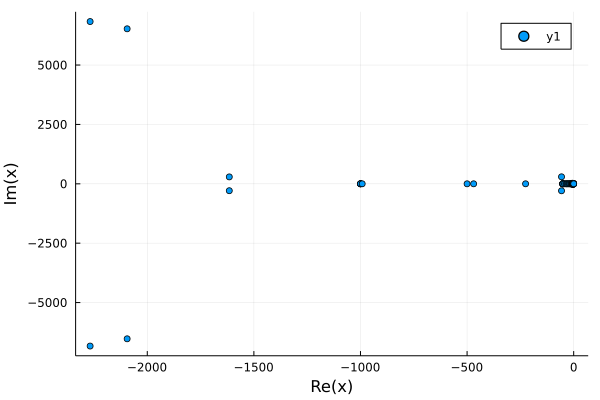

In [18]:
scatter(res.eigenvalues)

We execute the simulation

In [19]:
PSD.execute!(sim, IDA(); abstol = 1e-8)

SIMULATION_FINALIZED::BUILD_STATUS = 6

Using `PowerSimulationsDynamics` tools for exploring the results, we can plot all the voltage
results for the buses

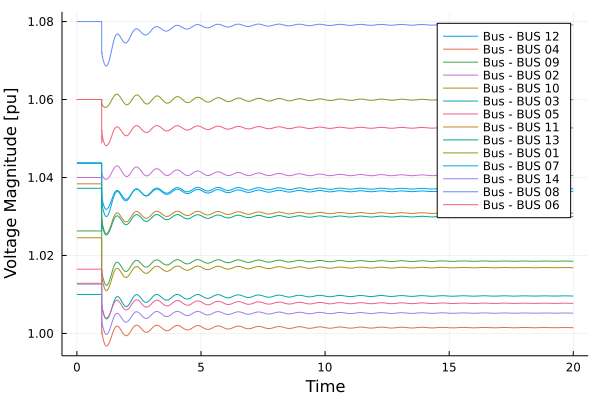

In [20]:
result = read_results(sim)
p = plot()
for b in get_components(Bus, sys)
    voltage_series = get_voltage_magnitude_series(result, get_number(b))
    plot!(
        p,
        voltage_series;
        xlabel = "Time",
        ylabel = "Voltage Magnitude [pu]",
        label = "Bus - $(get_name(b))",
    )
end
img = DisplayAs.PNG(p) # This line is only needed because of literate use display(p) when running locally

We can also explore the frequency of the different static generators and storage

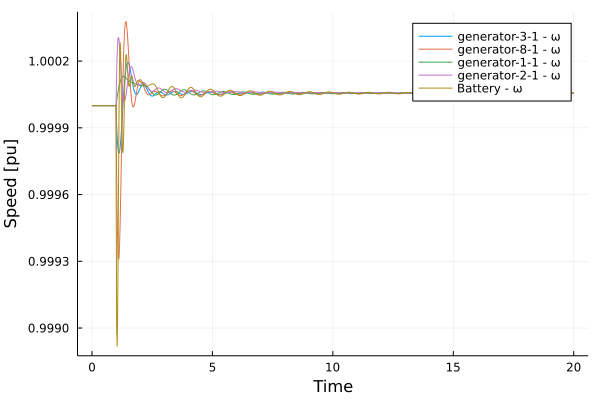

In [21]:
p2 = plot()
for g in get_components(ThermalStandard, sys)
    state_series = get_state_series(result, (get_name(g), :ω))
    plot!(
        p2,
        state_series;
        xlabel = "Time",
        ylabel = "Speed [pu]",
        label = "$(get_name(g)) - ω",
    )
end
state_series = get_state_series(result, ("Battery", :ω_oc))
plot!(p2, state_series; xlabel = "Time", ylabel = "Speed [pu]", label = "Battery - ω")
img = DisplayAs.PNG(p2) # This line is only needed because of literate use display(p2) when running locally

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*